In [1]:
import hydra
from hydra import initialize, compose
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error
import torch
from torch.distributions import Normal, Categorical
from scipy.stats import norm

from model import BaseTransformer
import time

import os
import copy
import seaborn as sns

from utils.misc import *
from utils import compute_ll, remove_design, load_checkpoint, add_design, create_target_mask, select_targets_by_mask

import warnings

warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
matplotlib.rcParams.update({
        'font.family': 'times',
        'font.size': 14.0,
        'lines.linewidth': 2,
        'lines.antialiased': True,
        'axes.facecolor': 'fdfdfd',
        'axes.edgecolor': '777777',
        'axes.linewidth': 1,
        'axes.titlesize': 'medium',
        'axes.labelsize': 'medium',
        'axes.axisbelow': True,
        'xtick.major.size': 0,  # major tick size in points
        'xtick.minor.size': 0,  # minor tick size in points
        'xtick.major.pad': 6,  # distance to major tick label in points
        'xtick.minor.pad': 6,  # distance to the minor tick label in points
        'xtick.color': '333333',  # color of the tick labels
        'xtick.labelsize': 'medium',  # fontsize of the tick labels
        'xtick.direction': 'in',  # direction: in or out
        'ytick.major.size': 0,  # major tick size in points
        'ytick.minor.size': 0,  # minor tick size in points
        'ytick.major.pad': 6,  # distance to major tick label in points
        'ytick.minor.pad': 6,  # distance to the minor tick label in points
        'ytick.color': '333333',  # color of the tick labels
        'ytick.labelsize': 'medium',  # fontsize of the tick labels
        'ytick.direction': 'in',  # direction: in or out
        'axes.grid': False,
        'grid.alpha': 0.3,
        'grid.linewidth': 1,
        'legend.fancybox': True,
        'legend.fontsize': 'Small',
        'figure.figsize': (2.5, 2.5),
        'figure.facecolor': '1.0',
        'figure.edgecolor': '0.5',
        'hatch.linewidth': 0.1,
        'text.usetex': True
    })


In [3]:
def load_config_and_model(path, config_name="config.yaml", pth_name="aae.pth"):
    """
    Loads configuration and model from a specified path. Instantiates the model components
    (embedder, encoder, and head) based on the configuration, and loads the model's checkpoint.
    """
    config_path = path + ".hydra/"
    print(config_path)
    with initialize(version_base=None, config_path=config_path):
        cfg = compose(config_name=config_name)

        embedder = hydra.utils.instantiate(cfg.embedder)
        encoder = hydra.utils.instantiate(cfg.encoder)
        head = hydra.utils.instantiate(cfg.head)
        model = BaseTransformer(embedder, encoder, head)

        ckpt = torch.load(os.path.join(path, pth_name), map_location=torch.get_default_device(), weights_only=False)
        model.load_state_dict(ckpt["model"])
    return cfg, model

In [4]:
def compute_rmse(samples, ground_truth):
    """
    Compute RMSE between samples and ground truth for each theta parameter.
    
    Args:
        samples: Tensor of shape [batch_size, n_theta, 1000] containing sampled values
        ground_truth: Tensor of shape [batch_size, n_theta, 1] containing true values
    
    Returns:
        Tensor of shape [batch_size, n_theta] containing RMSE values
    """
    # Expand ground_truth to match samples dimension
    expanded_truth = ground_truth.expand(-1, -1, samples.shape[2])
    
    # Compute squared differences
    squared_diff = (samples - expanded_truth) ** 2
    
    # Average over the samples dimension (dim=2) and take square root
    rmse = torch.sqrt(torch.mean(squared_diff, dim=2))
    
    return rmse

In [5]:
def sample(means, stds, weights, num_samples):
    mixture_dists = Categorical(weights, validate_args=False)
    component_indices = mixture_dists.sample((num_samples,))  # Shape [num_samples, n_targetxB]

    # Means and stds are of shape [B x n_target, num_components]
    # selects the means and stds for each sample based on mixture indices [num_samples, B x n_target, 1]
    selected_means = torch.gather(
        means.unsqueeze(0).expand(num_samples, -1, -1),
        2,
        component_indices.unsqueeze(-1),
    )
    selected_stds = torch.gather(
        stds.unsqueeze(0).expand(num_samples, -1, -1), 2, component_indices.unsqueeze(-1)
    )

    # Flatten to match the distribution requirements
    selected_means = selected_means.squeeze(-1)  # [num_samples, B x n_target]
    selected_stds = selected_stds.squeeze(-1)

    normal_dists = Normal(selected_means, selected_stds, validate_args=False)
    samples = normal_dists.sample()  # [num_samples, B x n_target]

    return samples.t() 

In [6]:
def visualize_theta_posteriors(mixture_means, mixture_stds, mixture_weights, true_theta=None, param_names=None):
    """
    Visualize marginal posteriors for theta parameters from GMM components.
    
    Args:
        mixture_means: GMM means [batch_size, 2, n_components]
        mixture_stds: GMM standard deviations [batch_size, 2, n_components]
        mixture_weights: GMM weights [batch_size, 2, n_components] or [batch_size, n_components]
        true_theta: True theta values if available [batch_size, 2]
        param_names: Names for the parameters, defaults to ["Lengthscale", "Variance"]
    """
    # Use first batch for simplicity
    if param_names is None:
        param_names = ["threshold", "slope", "guess_rate", "lapse_rate"]
        
    param_domain = {
        "threshold": [-3, 3],
        "slope": [0.1, 2],
        "guess_rate": [0.1, 0.9],
        "lapse_rate": [0, 0.5],
    }
    
    batch_idx = 0
    
    # Get dimensions
    n_params = mixture_means.shape[1]  # Should be 4
    n_components = mixture_means.shape[2]

    
    # Adjust weights if they don't have the parameter dimension
    if len(mixture_weights.shape) == 2:  # [batch_size, n_components]
        weights = mixture_weights[batch_idx].detach().numpy()
        weights = np.expand_dims(weights, 0).repeat(n_params, axis=0)
    else:  # [batch_size, 2, n_components]
        weights = mixture_weights[batch_idx].detach().numpy()
    
    # Convert to numpy
    means = mixture_means[batch_idx].detach().numpy()
    stds = mixture_stds[batch_idx].detach().numpy()
    
    # Create figure with two subplots for the two parameters
    fig, axes = plt.subplots(1, 4, figsize=(14, 3))
    
    log_probs = []
    
    for i in range(n_params):
        param_means = means[i]
        param_stds = stds[i]
        param_weights = weights[i]
        
        # Create a range of x values for plotting
        min_val = param_domain[param_names[i]][0]
        max_val = param_domain[param_names[i]][1]
        
        x_range = np.linspace(min_val, max_val, 500)
        
        # Compute the GMM PDF
        pdf = np.zeros_like(x_range)
        for j in range(n_components):
            component_pdf = norm.pdf(x_range, loc=param_means[j], scale=param_stds[j])
            weighted_pdf = param_weights[j] * component_pdf
            pdf += weighted_pdf
        
        # Plot the overall GMM PDF
        axes[i].plot(x_range, pdf, 'k-', linewidth=2, label="Posterior" if i == 0 else None)

        axes[i].axvline(true_theta[batch_idx, i, 0], color="r", linestyle="--", linewidth=1.5, label="Ground truth")
    
        axes[i].set_title(f"{param_names[i]} Posterior Distribution")
        axes[i].set_xlabel(f"{param_names[i]} Value")
        axes[i].set_ylabel("Probability Density")
        axes[i].grid(True)
    
    # Add legend to the first plot only
    axes[0].legend(loc='upper right')

    plt.tight_layout()
    plt.show()
    # return fig

In [7]:
all_rmse_qp = np.zeros([100, 50, 4])
all_rmse_psi_first_two = np.zeros([100, 50, 2])
all_rmse_psi_last_two = np.zeros([100, 30, 2])

for i in range(100):
    all_rmse_qp[i-1] = np.load(f"results/psychometric/questplus/rmse_{i}.npy")
    all_rmse_psi_first_two[i-1] = np.load(f"results/psychometric/psi_marginal_first_two/rmse_{i}.npy")
    all_rmse_psi_last_two[i-1] = np.load(f"results/psychometric/psi_marginal_last_two/rmse_last_two_{i}.npy")

all_rmse_qp = all_rmse_qp[:, :30, :]
all_rmse_psi_first_two = all_rmse_psi_first_two[:, :30, :]

In [8]:
T = 30
n_samples = 1000
n_components = 10

In [11]:
# Final
cfg, model = load_config_and_model(
    path="results/psychometric/aline/",
    pth_name="ckpt_psychometric.tar"
)

results/psychometric/aline/.hydra/


In [17]:
cfg_all, model_all = load_config_and_model(
    path="results/psychometric/aline_all/",
    pth_name="ckpt_psychometric.tar"
)

results/psychometric/aline_all/.hydra/


In [12]:
all_mask = torch.tensor([True, True, True, True], dtype=torch.bool)
first_two_mask = torch.tensor([True, True, False, False], dtype=torch.bool)
last_two_mask = torch.tensor([False, False, True, True], dtype=torch.bool)

In [13]:
cfg.task.n_context_init = 1
cfg.task.n_query_init = 200

experiment = hydra.utils.instantiate(cfg.task)
batch_size = 1000
eval_set = experiment.sample_batch(batch_size)

In [15]:
# torch.save(eval_set, "psychometric_eval_set.pt")
eval_set = torch.load("data/psychometric_eval_set.pt", weights_only=False)

In [16]:
def get_results(eval_set, model, mask, T, n_components, n_samples, visualize=True):
    batch = copy.deepcopy(eval_set)
    
    batch.target_mask = mask
    
    true_count = (mask == True).sum().item()
    selected_indices = torch.where(mask)[0]
    
    all_log_probs = torch.zeros([batch_size, T, true_count])
    all_rmse = torch.zeros([batch_size, T, true_count])
    queried_points = torch.zeros([T, 1])
    all_time = torch.zeros((T), device=batch.context_x.device)
    
    batch_idx = 0  # Work with first batch for visualization
    
    for t in range(T):
        if cfg.time_token:
            batch.t = torch.tensor([(T-t)/T])

        outs = model.forward(batch, predict=True)
        design_out = outs.design_out
        posterior_out = outs.posterior_out
        
        # Calculate log probability
        target_ll = compute_ll(
            batch.target_all[:, selected_indices, :],
            posterior_out.mixture_means[:, selected_indices, :],
            posterior_out.mixture_stds[:, selected_indices, :],
            posterior_out.mixture_weights[:, selected_indices, :]
        )
    
        # Sample some posterior points
        samples_flattened = sample(posterior_out.mixture_means[:, selected_indices, :].view(-1, n_components),
                               posterior_out.mixture_stds[:, selected_indices, :].view(-1, n_components),
                               posterior_out.mixture_weights[:, selected_indices, :].view(-1, n_components),
                               num_samples=n_samples)  # [BxT, num_samples]
        posterior_samples = samples_flattened.view(-1, true_count, n_samples)  # [BxT, num_samples] -> [B, T, num_samples]
    
        # Convert the bounds to a tensor for easy clipping
        lower_bounds = torch.tensor([-3, 0.1, 0.1, 0])[selected_indices]
        upper_bounds = torch.tensor([3, 2, 0.9, 0.5])[selected_indices]
        
        
        # Expand dimensions to match posterior_samples shape [batch, n_theta, 1000]
        lower_bounds = lower_bounds.view(1, true_count, 1).expand_as(posterior_samples)
        upper_bounds = upper_bounds.view(1, true_count, 1).expand_as(posterior_samples)
        
        # Clip the samples
        posterior_samples = torch.clamp(posterior_samples, min=lower_bounds, max=upper_bounds)
    
    
        all_rmse[:, t, :] = compute_rmse(posterior_samples, batch.target_all[:, selected_indices, :])
        all_log_probs[:, t, :] = target_ll.detach()
        
        # Get the next design point
        next_design_x = torch.gather(batch.query_x, 1, design_out.idx.unsqueeze(2).expand(batch_size, 1, cfg.task.dim_x))
        queried_points[t] = next_design_x[batch_idx].reshape(-1)
    
        # Update batch with the next design
        batch = experiment.update_batch(batch, design_out.idx)

    if visualize:
    
        visualize_theta_posteriors(
            posterior_out.mixture_means,
            posterior_out.mixture_stds,
            posterior_out.mixture_weights,
            true_theta=batch.target_theta)
        
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        plt.scatter(np.arange(queried_points.shape[0]), queried_points.detach().numpy(), label="Queries")
        plt.axhline(y=batch.target_theta[batch_idx, 0, 0], color='r', linestyle='--', linewidth=2, label='$\\alpha$')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        sns.kdeplot(queried_points, color = "C2", linewidth = 2, linestyle = "solid", label="Queries")
        plt.axvline(x=batch.target_theta[batch_idx, 0, 0], color='r', linestyle='--', linewidth=2, label='$\\alpha$')
        plt.legend()
        
        plt.show()
    return all_rmse, all_log_probs

In [20]:
all_four_rmse, all_four_log_probs = get_results(eval_set, model_all, all_mask, T, n_components, n_samples, visualize=False)

all_first_two_rmse, all_first_two_log_probs = get_results(eval_set, model, first_two_mask, T, n_components, n_samples, visualize=False)
all_last_two_rmse, all_last_two_log_probs = get_results(eval_set, model, last_two_mask, T, n_components, n_samples, visualize=False)

In [21]:
all_first_two_rmse_full = all_four_rmse[:, :, :2]
all_last_two_rmse_full = all_four_rmse[:, :, 2:]

first_two_rmse_full = all_first_two_rmse_full.mean(axis=2)  # [batch_size, T]
first_two_mean_full = first_two_rmse_full.mean(axis=0)  # [T]
first_two_std_full = first_two_rmse_full.std(axis=0)  # [T]
first_two_se_full = first_two_std_full / np.sqrt(batch_size)
first_two_lower_full = first_two_mean_full - 1.96 * first_two_se_full
first_two_upper_full = first_two_mean_full + 1.96 * first_two_se_full

last_two_rmse_full = all_last_two_rmse_full.mean(axis=2)  # [batch_size, T]
last_two_mean_full = last_two_rmse_full.mean(axis=0)  # [T]
last_two_std_full = last_two_rmse_full.std(axis=0)  # [T]
last_two_se_full = last_two_std_full / np.sqrt(batch_size)
last_two_lower_full = last_two_mean_full - 1.96 * last_two_se_full
last_two_upper_full = last_two_mean_full + 1.96 * last_two_se_full

In [22]:
# For first two parameters (Threshold and Slope)
# Calculate the mean RMSE for the first two parameters for each batch
first_two_rmse = all_first_two_rmse.mean(axis=2)  # [batch_size, T]
first_two_rmse_qp = all_rmse_qp[:, :, :2].mean(axis=2)  # [batch_size, T]
first_two_rmse_psi = all_rmse_psi_first_two[:, :, :].mean(axis=2)  # [batch_size, T]

# Calculate statistics across batches
first_two_mean = first_two_rmse.mean(axis=0)  # [T]
first_two_mean_qp = first_two_rmse_qp.mean(axis=0)  # [T]
first_two_mean_psi = first_two_rmse_psi.mean(axis=0)  # [T]
first_two_std = first_two_rmse.std(axis=0)  # [T]
first_two_std_qp = first_two_rmse_qp.std(axis=0)  # [T]
first_two_std_psi = first_two_rmse_psi.std(axis=0)  # [T]

# Calculate confidence intervals
first_two_se = first_two_std / np.sqrt(batch_size)
first_two_se_qp = first_two_std_qp / np.sqrt(batch_size)
first_two_se_psi = first_two_std_psi / np.sqrt(batch_size)
first_two_lower = first_two_mean - 1.96 * first_two_se
first_two_upper = first_two_mean + 1.96 * first_two_se
first_two_lower_qp = first_two_mean_qp - 1.96 * first_two_se_qp
first_two_upper_qp = first_two_mean_qp + 1.96 * first_two_se_qp
first_two_lower_psi = first_two_mean_psi - 1.96 * first_two_se_psi
first_two_upper_psi = first_two_mean_psi + 1.96 * first_two_se_psi

# For last two parameters (Guess Rate and Lapse Rate)
# Calculate the mean RMSE for the last two parameters for each batch
last_two_rmse = all_last_two_rmse.mean(axis=2)  # [batch_size, T]
last_two_rmse_qp = all_rmse_qp[:, :, 2:].mean(axis=2)  # [batch_size, T]
last_two_rmse_psi = all_rmse_psi_last_two.mean(axis=2)  # [batch_size, T]

# Calculate statistics across batches
last_two_mean = last_two_rmse.mean(axis=0)  # [T]
last_two_mean_qp = last_two_rmse_qp.mean(axis=0)  # [T]
last_two_mean_psi = last_two_rmse_psi.mean(axis=0)  # [T]
last_two_std = last_two_rmse.std(axis=0)  # [T]
last_two_std_qp = last_two_rmse_qp.std(axis=0)  # [T]
last_two_std_psi = last_two_rmse_psi.std(axis=0)  # [T]

# Calculate confidence intervals
last_two_se = last_two_std / np.sqrt(batch_size)
last_two_se_qp = last_two_std_qp / np.sqrt(batch_size)
last_two_se_psi = last_two_std_psi / np.sqrt(batch_size)
last_two_lower = last_two_mean - 1.96 * last_two_se
last_two_upper = last_two_mean + 1.96 * last_two_se
last_two_lower_qp = last_two_mean_qp - 1.96 * last_two_se_qp
last_two_upper_qp = last_two_mean_qp + 1.96 * last_two_se_qp
last_two_lower_psi = last_two_mean_psi - 1.96 * last_two_se_psi
last_two_upper_psi = last_two_mean_psi + 1.96 * last_two_se_psi

In [44]:
# torch.save(first_two_points, "data/first_two_points.pt")
# torch.save(first_two_y, "data/first_two_y.pt")
# torch.save(last_two_points, "data/last_two_points.pt")
# torch.save(last_two_y, "data/last_two_y.pt")

first_two_points = torch.load("data/first_two_points.pt", weights_only=False)
first_two_y = torch.load("data/first_two_y.pt", weights_only=False)
last_two_points = torch.load("data/last_two_points.pt", weights_only=False)
last_two_y = torch.load("data/last_two_y.pt", weights_only=False)

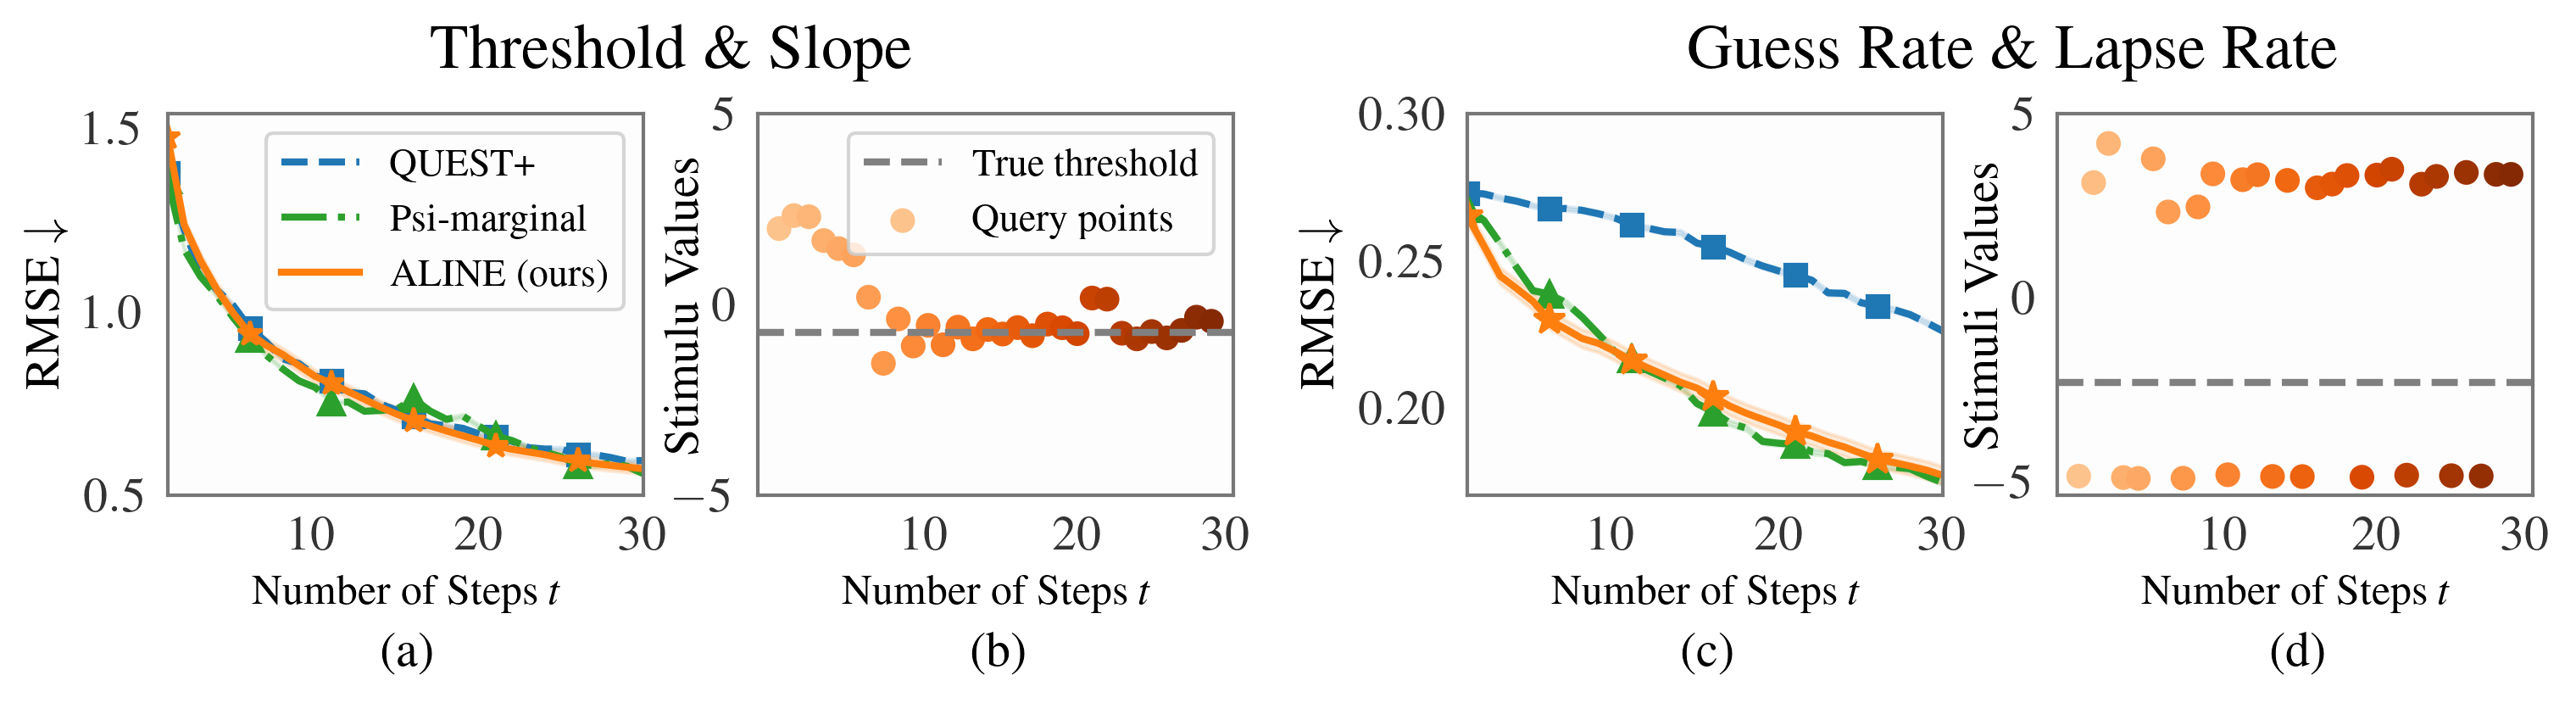

In [45]:
colors = {
        'blue': "C1",
        'red': "C0",
        'green': "C2"}

# Line styles and markers
line_styles = {
    'ALIEN': '-',
    'QUEST+': '--',
    'Psi-marginal': '-.'
}

markers = {
    'ALIEN': '*',
    'QUEST+': 's',
    'Psi-marginal': '^'
}

# --- Corrected GridSpec Setup ---
# Create the figure instance
fig = plt.figure(figsize=(12, 2.5), dpi=300)
plt.rcParams.update({'font.family': 'times'})

# Define the main GridSpec: 1 row, 2 columns (for the two groups)
# wspace controls the space BETWEEN these two main columns (make it larger)
gs_main = GridSpec(1, 2, figure=fig, wspace=0.22) # Adjust wspace for gap between group 1-2 and 3-4

# *** Use GridSpecFromSubplotSpec for nested grids ***
# Create nested GridSpec for the first group (plots 1 & 2) within the first column of gs_main
# wspace controls the space WITHIN this group (make it smaller)
gs_left = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_main[0], wspace=0.24) # <= CORRECT CLASS

# Create nested GridSpec for the second group (plots 3 & 4) within the second column of gs_main
# wspace controls the space WITHIN this group (make it smaller)
gs_right = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_main[1], wspace=0.24) # <= CORRECT CLASS

# Create axes using the nested GridSpec definitions
ax0 = fig.add_subplot(gs_left[0]) # First plot
ax1 = fig.add_subplot(gs_left[1]) # Second plot
ax2 = fig.add_subplot(gs_right[0])# Third plot
ax3 = fig.add_subplot(gs_right[1])# Fourth plot

axes = [ax0, ax1, ax2, ax3] # Keep this list if useful elsewhere
# --- End Corrected GridSpec Setup ---


# X-axis values (number of queries)
x = np.arange(1, T+1)  # Start from 1, end at T
marker_indices = np.arange(0, T, 5)  # Add markers every 5 steps

# --- Plotting code remains the same, using ax0, ax1, ax2, ax3 ---

# Plot for the first two parameters (Threshold and Slope)
ax = ax0
# QUEST+
ax.plot(x, first_two_mean_qp, color=colors['red'], linestyle=line_styles['QUEST+'], linewidth=2, label='QUEST+')
ax.plot(x[marker_indices], first_two_mean_qp[marker_indices], color=colors['red'], marker=markers['QUEST+'], markersize=6, linestyle='None')
ax.fill_between(x, first_two_lower_qp, first_two_upper_qp, color=colors['red'], alpha=0.15)
# Psi-marginal
ax.plot(x, first_two_mean_psi, color=colors['green'], linestyle=line_styles['Psi-marginal'], linewidth=2, label='Psi-marginal')
ax.plot(x[marker_indices], first_two_mean_psi[marker_indices], color=colors['green'], marker=markers['Psi-marginal'], markersize=7, linestyle='None')
ax.fill_between(x, first_two_lower_psi, first_two_upper_psi, color=colors['green'], alpha=0.15)
# ALIEN
ax.plot(x, first_two_mean, color=colors['blue'], linestyle=line_styles['ALIEN'], linewidth=2, label='ALINE (ours)')
ax.plot(x[marker_indices], first_two_mean[marker_indices], color=colors['blue'], marker=markers['ALIEN'], markersize=7, linestyle='None')
ax.fill_between(x, first_two_lower, first_two_upper, color=colors['blue'], alpha=0.15)
ax.set_xlabel('Number of Steps $t$', size=12)
ax.set_ylabel('RMSE $\\downarrow$')
ax.set_yticks([0.5, 1.0, 1.5])
ax.set_xlim(1, T)
ax.legend(loc='upper right', fontsize=11)
ax.text(0.45, -0.45, '(a)', transform=ax.transAxes, fontsize=14, fontweight='bold')

# Plot for the second subplot
ax = ax1
cmap = plt.cm.Oranges
norm = plt.Normalize(0, len(first_two_points))
scatter_colors = [cmap(0.3 + 0.7 * norm(i)) for i in range(T)]
ax.axhline(y=first_two_y, color='grey', linestyle='--', linewidth=2, label='True threshold')
ax.scatter(np.arange(T), first_two_points[:T], c=scatter_colors, label='Query points')
ax.set_xlabel('Number of Steps $t$', size=12)
ax.set_ylabel('Stimulu Values', labelpad=-10)
ax.set_yticks([-5, 0, 5])
ax.legend(loc='upper right', fontsize=11)
ax.set_xticks([10, 20, 30])
ax.text(0.45, -0.45, '(b)', transform=ax.transAxes, fontsize=14, fontweight='bold')

fig.text(0.29, 0.9, 'Threshold \& Slope', ha='center', va='bottom', fontsize=18, fontweight='extra bold')

# Plot for the last two parameters
ax = ax2
# QUEST+
ax.plot(x, last_two_mean_qp, color=colors['red'], linestyle=line_styles['QUEST+'], linewidth=2, label='QUEST+')
ax.plot(x[marker_indices], last_two_mean_qp[marker_indices], color=colors['red'], marker=markers['QUEST+'], markersize=6, linestyle='None')
ax.fill_between(x, last_two_lower_qp, last_two_upper_qp, color=colors['red'], alpha=0.15)
# Psi-marginal
ax.plot(x, last_two_mean_psi, color=colors['green'], linestyle=line_styles['Psi-marginal'], linewidth=2, label='Psi-marginal')
ax.plot(x[marker_indices], last_two_mean_psi[marker_indices], color=colors['green'], marker=markers['Psi-marginal'], markersize=7, linestyle='None')
ax.fill_between(x, last_two_lower_psi, last_two_upper_psi, color=colors['green'], alpha=0.15)
# ALIEN
ax.plot(x, last_two_mean, color=colors['blue'], linestyle=line_styles['ALIEN'], linewidth=2, label='ALINE')
ax.plot(x[marker_indices], last_two_mean[marker_indices], color=colors['blue'], marker=markers['ALIEN'], markersize=9, linestyle='None')
ax.fill_between(x, last_two_lower, last_two_upper, color=colors['blue'], alpha=0.15)
ax.set_xlabel('Number of Steps $t$', size=12)
ax.set_ylabel('RMSE $\\downarrow$')
ax.set_xlim(1, T)
ax.set_ylim(0.17, 0.30)
# ax.legend(loc='upper right', fontsize=10)
ax.text(0.45, -0.45, '(c)', transform=ax.transAxes, fontsize=14, fontweight='bold')

# Plot for the fourth subplot
ax = ax3
scatter_colors_last = [cmap(0.3 + 0.7 * norm(i)) for i in range(T)]
ax.axhline(y=last_two_y, color='grey', linestyle='--', linewidth=2, label='True threshold')
ax.scatter(np.arange(T), last_two_points[:T], c=scatter_colors_last, label="Query points")
ax.set_xlabel('Number of Steps $t$', size=12)
ax.set_ylabel('Stimuli Values', labelpad=-10)
ax.set_yticks([-5, 0, 5])
ax.set_xticks([10, 20, 30])
# ax.legend(loc=7, fontsize=10)
fig.text(0.73, 0.9, 'Guess Rate \& Lapse Rate', ha='center', va='bottom', fontsize=18, fontweight='extra bold')
ax.text(0.45, -0.45, '(d)', transform=ax.transAxes, fontsize=14, fontweight='bold')


# Adjust layout
plt.subplots_adjust(bottom=0.25, top=0.85) # Keep manual adjustment
plt.tight_layout()
# plt.savefig('figures/psychometric.pdf', bbox_inches='tight')

plt.show()


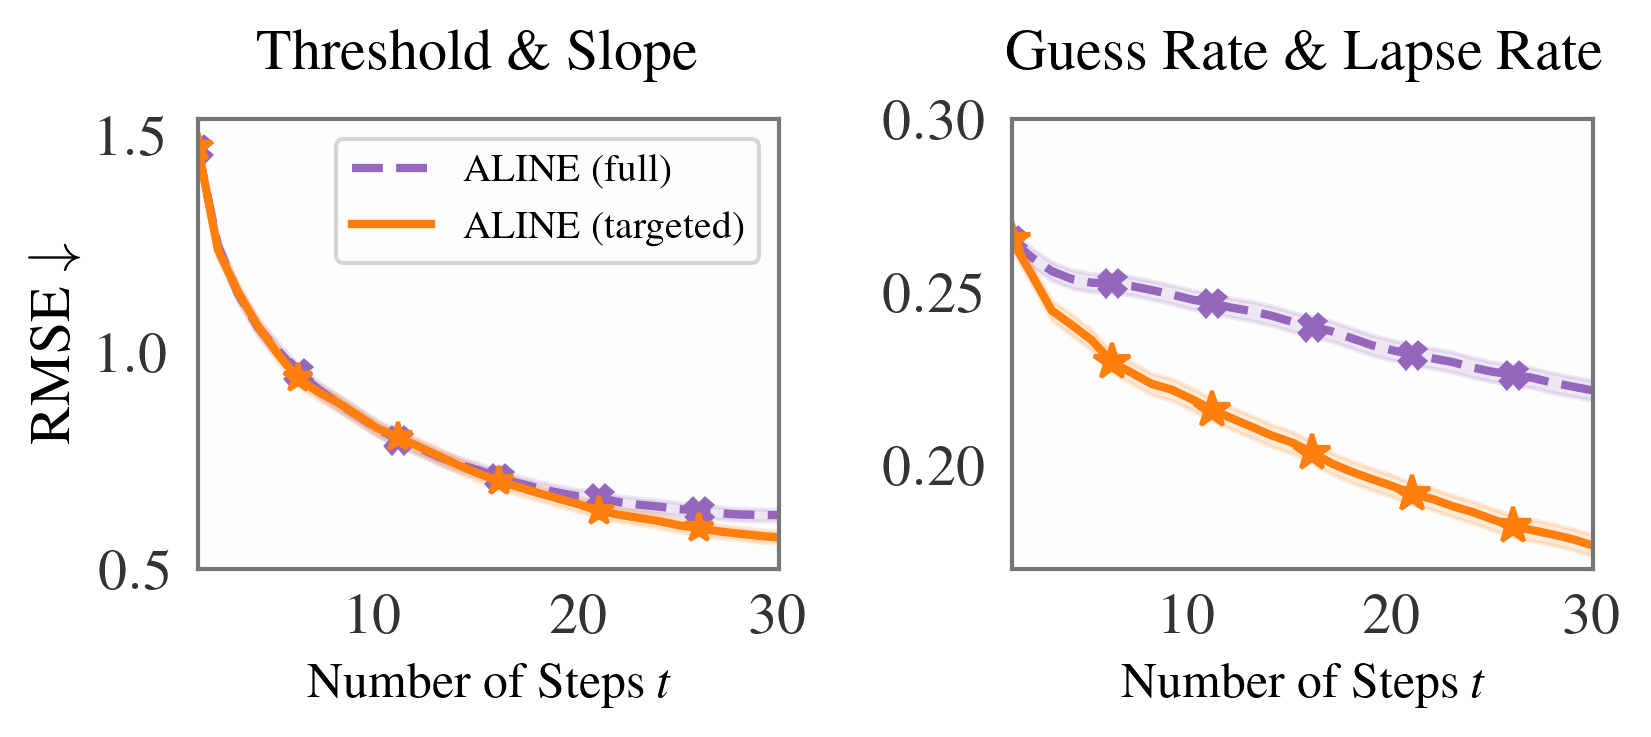

In [46]:
colors = {
        'purple': "C4",
        'orange': "C1",
        'red': "C0",
        'green': "C2"}

# Line styles and markers
line_styles = {
    'ALINE_full': '--',
    'ALINE': '-',
    'QUEST+': '--',
    'Psi-marginal': '-.'
}

markers = {
    'ALINE_full': 'X',
    'ALINE': '*',
    'QUEST+': 's',
    'Psi-marginal': '^'
}

# --- Corrected GridSpec Setup ---
# Create the figure instance
fig = plt.figure(figsize=(6, 2.5), dpi=300)
plt.rcParams.update({'font.family': 'times'})

# Define the main GridSpec: 1 row, 2 columns (for the two groups)
# wspace controls the space BETWEEN these two main columns (make it larger)
gs_main = GridSpec(1, 2, figure=fig, wspace=0.4) # Adjust wspace for gap between group 1-2 and 3-4

# *** Use GridSpecFromSubplotSpec for nested grids ***
# Create nested GridSpec for the first group (plots 1 & 2) within the first column of gs_main
# wspace controls the space WITHIN this group (make it smaller)
gs_left = GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0], wspace=0.24) # <= CORRECT CLASS

# Create nested GridSpec for the second group (plots 3 & 4) within the second column of gs_main
# wspace controls the space WITHIN this group (make it smaller)
gs_right = GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[1], wspace=0.24) # <= CORRECT CLASS

# Create axes using the nested GridSpec definitions
ax0 = fig.add_subplot(gs_left[0]) # First plot

ax2 = fig.add_subplot(gs_right[0])# Third plot


axes = [ax0, ax1, ax2, ax3] # Keep this list if useful elsewhere
# --- End Corrected GridSpec Setup ---


# X-axis values (number of queries)
x = np.arange(1, T+1)  # Start from 1, end at T
marker_indices = np.arange(0, T, 5)  # Add markers every 5 steps


# Plot for the first two parameters (Threshold and Slope)
ax = ax0

# ALIEN (full)
ax.plot(x, first_two_mean_full, color=colors['purple'], linestyle=line_styles['ALINE_full'], linewidth=2, label='ALINE (full)')
ax.plot(x[marker_indices], first_two_mean_full[marker_indices], color=colors['purple'], marker=markers['ALINE_full'], markersize=6, linestyle='None')
ax.fill_between(x, first_two_lower_full, first_two_upper_full, color=colors['purple'], alpha=0.15)
# ALIEN
ax.plot(x, first_two_mean, color=colors['orange'], linestyle=line_styles['ALINE'], linewidth=2, label='ALINE (targeted)')
ax.plot(x[marker_indices], first_two_mean[marker_indices], color=colors['orange'], marker=markers['ALINE'], markersize=7, linestyle='None')
ax.fill_between(x, first_two_lower, first_two_upper, color=colors['orange'], alpha=0.15)
ax.set_xlabel('Number of Steps $t$', size=12)
ax.set_ylabel('RMSE $\\downarrow$')
ax.set_yticks([0.5, 1.0, 1.5])
ax.set_xlim(1, T)
ax.legend(loc='upper right', fontsize=9.5)


fig.text(0.28, 0.9, 'Threshold \& Slope', ha='center', va='bottom', fontsize=14, fontweight='extra bold')

# Plot for the last two parameters
ax = ax2

# ALIEN (full)
ax.plot(x, last_two_mean_full, color=colors['purple'], linestyle=line_styles['ALINE_full'], linewidth=2, label='ALINE (targeted)')
ax.plot(x[marker_indices], last_two_mean_full[marker_indices], color=colors['purple'], marker=markers['ALINE_full'], markersize=6, linestyle='None')
ax.fill_between(x, last_two_lower_full, last_two_upper_full, color=colors['purple'], alpha=0.15)
# ALIEN
ax.plot(x, last_two_mean, color=colors['orange'], linestyle=line_styles['ALINE'], linewidth=2, label='ALINE')
ax.plot(x[marker_indices], last_two_mean[marker_indices], color=colors['orange'], marker=markers['ALINE'], markersize=9, linestyle='None')
ax.fill_between(x, last_two_lower, last_two_upper, color=colors['orange'], alpha=0.15)
ax.set_xlabel('Number of Steps $t$', size=12)
# ax.set_ylabel('RMSE $\\downarrow$')
ax.set_xlim(1, T)
ax.set_ylim(0.17, 0.30)
# ax.legend(loc='upper right', fontsize=10)

# Plot for the fourth subplot
fig.text(0.74, 0.9, 'Guess Rate \& Lapse Rate', ha='center', va='bottom', fontsize=14, fontweight='extra bold')

# Adjust layout
plt.subplots_adjust(bottom=0.25, top=0.85) # Keep manual adjustment
plt.tight_layout()
# plt.savefig('figures/psychometric_ablation.pdf', bbox_inches='tight')

plt.show()
